# House Price Prediction
- 출처 : https://www.kaggle.com/competitions/2019-2nd-ml-month-with-kakr

- 집의 정보를 이용하여 가격을 예측하는 방식 (Regression 문제)
- RMSE를 이용하여 모델의 정확도를 평가함

In [1]:
import warnings
warnings.filterwarnings("ignore")

import os
from os.path import join

import pandas as pd
import numpy as np

import missingno as msno

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import KFold, cross_val_score
import xgboost as xgb
import lightgbm as lgb 

import matplotlib.pyplot as plt
import seaborn as sns

# 데이터 불러오기

In [2]:
data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'

train_data_path = join(data_dir, 'train.csv')
test_data_path = join(data_dir, 'test.csv') 

train = pd.read_csv(train_data_path)
test = pd.read_csv(test_data_path)

In [3]:
print(train.shape, test.shape)
train.head()

(15035, 21) (6468, 20)


,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,20140627T000000,257500.0,3,2.25,1715,6819,2.0,0,0,...,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,20150115T000000,291850.0,3,1.50,1060,9711,1.0,0,0,...,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


- 15035의 train 데이터와 6468개의 test 데이터셋으로 이루어져있다

## EDA

### 데이터 살펴보기

In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15035 entries, 0 to 15034
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             15035 non-null  int64  
 1   date           15035 non-null  object 
 2   price          15035 non-null  float64
 3   bedrooms       15035 non-null  int64  
 4   bathrooms      15035 non-null  float64
 5   sqft_living    15035 non-null  int64  
 6   sqft_lot       15035 non-null  int64  
 7   floors         15035 non-null  float64
 8   waterfront     15035 non-null  int64  
 9   view           15035 non-null  int64  
 10  condition      15035 non-null  int64  
 11  grade          15035 non-null  int64  
 12  sqft_above     15035 non-null  int64  
 13  sqft_basement  15035 non-null  int64  
 14  yr_built       15035 non-null  int64  
 15  yr_renovated   15035 non-null  int64  
 16  zipcode        15035 non-null  int64  
 17  lat            15035 non-null  float64
 18  long  

    ID : 집을 구분하는 번호
    date : 집을 구매한 날짜
    price : 타겟 변수인 집의 가격
    bedrooms : 침실의 수
    bathrooms : 침실당 화장실 개수
    sqft_living : 주거 공간의 평방 피트
    sqft_lot : 부지의 평방 피트
    floors : 집의 층 수
    waterfront : 집의 전방에 강이 흐르는지 유무 (a.k.a. 리버뷰)
    view : 집이 얼마나 좋아 보이는지의 정도
    condition : 집의 전반적인 상태
    grade : King County grading 시스템 기준으로 매긴 집의 등급
    sqft_above : 지하실을 제외한 평방 피트
    sqft_basement : 지하실의 평방 피트
    yr_built : 집을 지은 년도
    yr_renovated : 집을 재건축한 년도
    zipcode : 우편번호
    lat : 위도
    long : 경도
    sqft_living15 : 2015년 기준 주거 공간의 평방 피트(집을 재건축했다면, 변화가 있을 수 있음)
    sqft_lot15 : 2015년 기준 부지의 평방 피트(집을 재건축했다면, 변화가 있을 수 있음)

- 문자열 type의 데이터는 없고 모두 수치형 데이터로 구성되어있다.
- date가 object 타입이긴한데 데이터 특성상 시계열 데이터이므로 datetime 형태로 변환해 줄 것이다
- 수치형 데이터이더라도 이진분류가 되는 binary 형태나 등급같은 것은 범주형 데이터의 형태일 것으로 보인다.
    - 수치형과 범주형 데이터를 나눠서 분석을 해줄 것이다

## ID : 집을 구분하는 번호

In [5]:
train.shape

(15035, 21)

In [6]:
train.id.nunique()

15035

- id의 값은 unique 하므로 인덱스와 일치하기에 id를 index로 변경하거나 없애주어도 된다
- test data도 동일하게 전처리를 진행한다

In [7]:
# id를 index로
# train.set_index('id', inplace=True)
# test.set_index('id', inplace=True)

In [8]:
del train['id']
del test['id']

In [9]:
train.head()

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,20140627T000000,257500.0,3,2.25,1715,6819,2.0,0,0,3,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,20150115T000000,291850.0,3,1.50,1060,9711,1.0,0,0,3,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


In [10]:
test.head()

,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,20141209T000000,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
1,20141209T000000,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
2,20140512T000000,4,4.50,5420,101930,1.0,0,0,3,11,3890,1530,2001,0,98053,47.6561,-122.005,4760,101930
3,20150415T000000,3,1.00,1780,7470,1.0,0,0,3,7,1050,730,1960,0,98146,47.5123,-122.337,1780,8113
4,20150312T000000,3,2.50,1890,6560,2.0,0,0,3,7,1890,0,2003,0,98038,47.3684,-122.031,2390,7570


## date : 집을 구매한 날짜

In [11]:
train['date'][0]

'20141013T000000'

In [12]:
train['date'].str.split('T').str[1].unique()

array(['000000'], dtype=object)

- T 뒤에는 의미없는 숫자들인 것 같고 앞에는 날짜정보를 가지고 있으므로 전처리를 통해 datetime형식으로 변환해준다

In [13]:
def extract_date_info(train):
    # 날짜 정보 분리 후 datetime으로 형식 변환
    train['date'] = train['date'].str.split('T').str[0]
    train['date'] = pd.to_datetime(train['date'])

    # 시간 관련 여러 파생변수 추출
    train['year'] = train.date.dt.year
    train['month'] = train.date.dt.month
    train['day'] = train.date.dt.day

    train['day_of_week'] = train.date.dt.day_of_week
    train['day_name'] = train.date.dt.day_name()
    train['quarter'] = train.date.dt.quarter
    
    train.drop('date', axis=1, inplace=True)

In [14]:
extract_date_info(train)

In [15]:
train.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,...,lat,long,sqft_living15,sqft_lot15,year,month,day,day_of_week,day_name,quarter
0,221900.0,3,1.00,1180,5650,1.0,0,0,3,7,...,47.5112,-122.257,1340,5650,2014,10,13,0,Monday,4
1,180000.0,2,1.00,770,10000,1.0,0,0,3,6,...,47.7379,-122.233,2720,8062,2015,2,25,2,Wednesday,1
2,510000.0,3,2.00,1680,8080,1.0,0,0,3,8,...,47.6168,-122.045,1800,7503,2015,2,18,2,Wednesday,1
3,257500.0,3,2.25,1715,6819,2.0,0,0,3,7,...,47.3097,-122.327,2238,6819,2014,6,27,4,Friday,2
4,291850.0,3,1.50,1060,9711,1.0,0,0,3,7,...,47.4095,-122.315,1650,9711,2015,1,15,3,Thursday,1


In [16]:
# test data에도 마찬가지로 같이 전처리를 해준다
extract_date_info(test)

### 시간 관련 변수 시각화

In [17]:
date_col = ['year','month','day','day_of_week','day_name','quarter']

In [18]:
train[date_col]

,year,month,day,day_of_week,day_name,quarter
0,2014,10,13,0,Monday,4
1,2015,2,25,2,Wednesday,1
2,2015,2,18,2,Wednesday,1
3,2014,6,27,4,Friday,2
4,2015,1,15,3,Thursday,1
...,...,...,...,...,...,...
15030,2014,10,14,1,Tuesday,4
15031,2015,3,26,3,Thursday,1
15032,2014,5,21,2,Wednesday,2
15033,2015,2,23,0,Monday,1


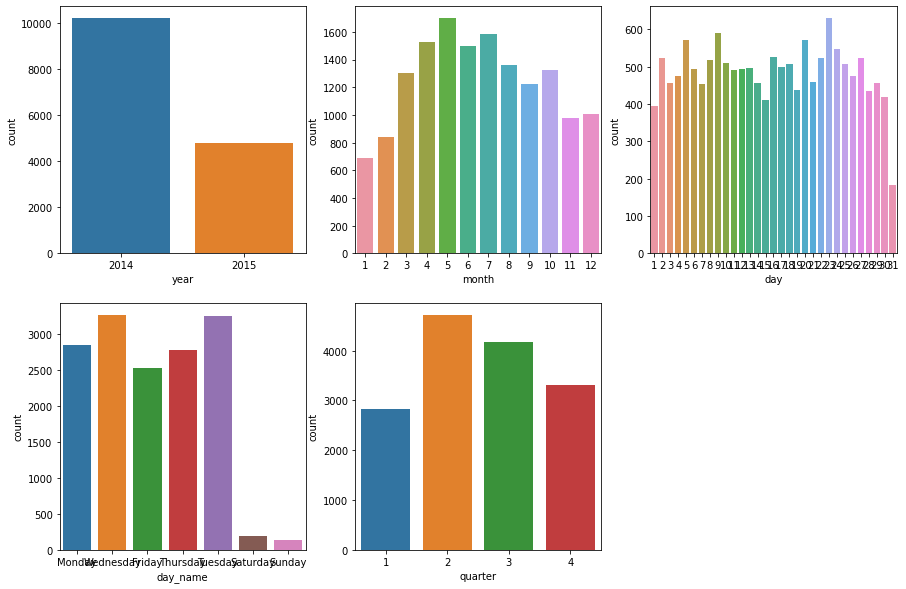

In [19]:
plt.figure(figsize = (15,10))

for i, col in enumerate(['year','month','day','day_name','quarter']):
    plt.subplot(2,3,i+1)
    sns.countplot(train[col])

- 2014년에 비해 2015년에 집 구매가 줄었다
- 5, 6, 7월에 주로 집을 구매하며 1월, 2월, 11월, 12월의 구매가 현저히 적다
- 31일이 없는 달도 있으므로 31일이 적은 것은 당연한 수치이지만 1일은 확실히 적은 수치인 것 같다.
- 구매일자는 주로 평일이 많고 주말에는 구매를 잘 하지 않는다는 것을 볼 수 있다
    - 부동산 매매업이 주로 평일에 영업을 해서 그런것으로 추정된다. 그렇다하더라도 수요일에는 구매가 적고 금요일에 구매가 많이 이루어진다
- 분기별로 비교했을 때, 2,3분기에 주로 구매한다

## price : 타겟 변수인 집의 가격
- price는 타겟 변수이므로 y에 할당해준다

In [20]:
y = train['price']

# 데이터 분석을 위해 아직 지우지는 않는 것이 편할 것 같아 지우지 않을 것이다
# train.drop('price', axis=1, inplace=True)
# train.columns

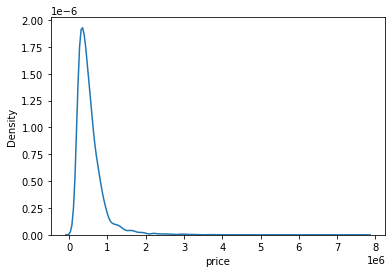

In [21]:
# y의 분포 확인

sns.kdeplot(y)
plt.show()

- price는 왼쪽으로 크게 치우쳐 있는 형태를 보인다.

따라서 y는 np.log1p() 함수를 통해 로그 변환을 해주고, 나중에 모델이 값을 예측한 후에 다시 np.expm1()을 활용해서 되돌려 줄 것이다. 

In [22]:
y = np.log1p(y)
y

0        12.309987
1        12.100718
2        13.142168
3        12.458779
4        12.583999
           ...    
15030    13.322338
15031    13.822984
15032    12.793862
15033    12.899222
15034    12.691584
Name: price, Length: 15035, dtype: float64

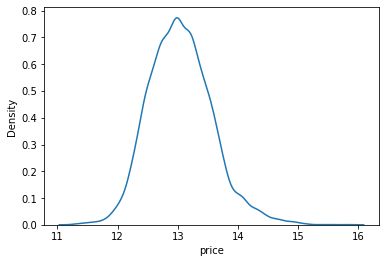

In [23]:
sns.kdeplot(y)
plt.show()

## bedrooms : 침실의 수, bathrooms : 침실당 화장실 개수

In [24]:
cols = ['bedrooms', 'bathrooms']

In [25]:
train[col].describe()

count    15035.000000
mean         2.528833
std          1.032473
min          1.000000
25%          2.000000
50%          2.000000
75%          3.000000
max          4.000000
Name: quarter, dtype: float64

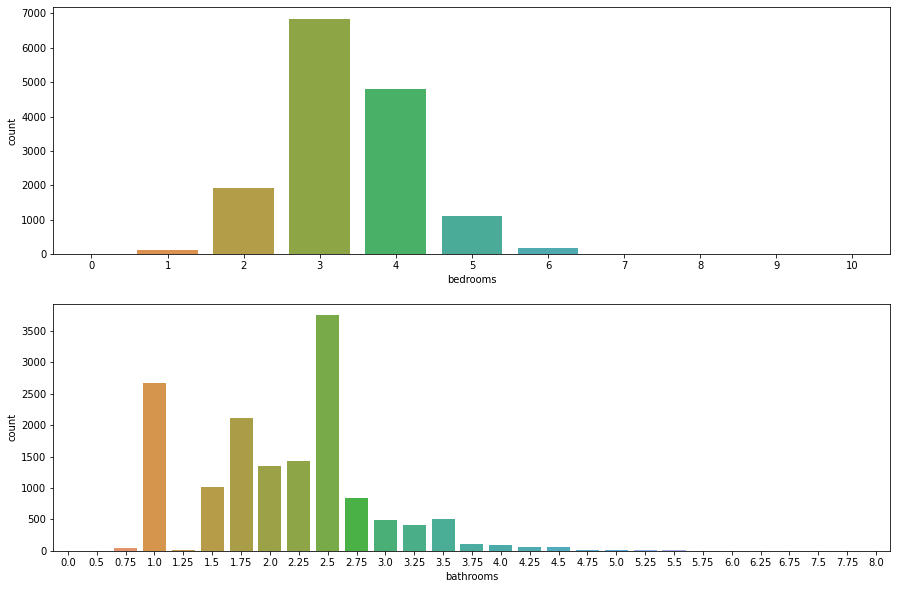

In [26]:
plt.figure(figsize = (15,10))

for i, col in enumerate(cols):
    plt.subplot(2,1,i+1)
    sns.countplot(train[col])

### 방의 개수와 화장실의 개수의 관계

<AxesSubplot:xlabel='bedrooms', ylabel='bathrooms'>

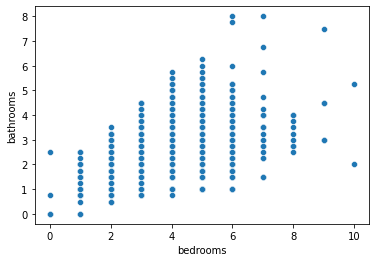

In [27]:
sns.scatterplot(x='bedrooms', y='bathrooms', data=train)

- 여기서 최솟값인 0인 데이터가 눈에 띈다 방이 침실과 화장실이 없는 데이터는 무엇일까?
- 그리고 화장실에서 0.5 값은 무엇일까?

원본 데이터를 확인 해봤다
- bathrooms : Number of bathrooms, where .5 accounts for a room with a toilet but no shower
- 변기만 있고 shower 공간이 없는 화장실을 .5로 본다고 써있었다

In [28]:
train[(train.bedrooms == 0) | (train.bathrooms == 0)]

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,...,lat,long,sqft_living15,sqft_lot15,year,month,day,day_of_week,day_name,quarter
4123,280000.0,1,0.00,600,24501,1.0,0,0,2,3,...,47.5316,-121.749,990,22549,2014,11,4,1,Tuesday,4
6885,235000.0,0,0.00,1470,4800,2.0,0,0,3,7,...,47.5265,-121.828,1060,7200,2014,12,23,1,Tuesday,4
7322,484000.0,1,0.00,690,23244,1.0,0,0,4,7,...,47.6429,-121.955,1690,19290,2014,9,18,3,Thursday,3
8826,320000.0,0,2.50,1490,7111,2.0,0,0,3,7,...,47.5261,-121.826,1500,4675,2015,2,18,2,Wednesday,1
12781,265000.0,0,0.75,384,213444,1.0,0,0,3,4,...,47.4177,-122.491,1920,224341,2014,10,29,2,Wednesday,4
13522,142000.0,0,0.00,290,20875,1.0,0,0,1,1,...,47.5308,-121.888,1620,22850,2014,9,26,4,Friday,3


- 확실히 방이 0개인데 화장실이 2.5개인 집은 상당히 이상한 데이터로 보인다.
- 일단 6개이므로 제거해준다

In [29]:
odd_index = train[(train.bedrooms == 0) | (train.bathrooms == 0)].index

In [30]:
train.drop(odd_index, inplace=True)

In [31]:
train.describe()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,...,zipcode,lat,long,sqft_living15,sqft_lot15,year,month,day,day_of_week,quarter
count,1.502900e+04,15029.000000,15029.000000,15029.000000,1.502900e+04,15029.000000,15029.000000,15029.000000,15029.000000,15029.000000,...,15029.000000,15029.000000,15029.000000,15029.000000,15029.000000,15029.000000,15029.000000,15029.000000,15029.000000,15029.000000
mean,5.407837e+05,3.370351,2.115693,2084.294497,1.528351e+04,1.498137,0.007120,0.234347,3.406947,7.661854,...,98078.041453,47.560733,-122.213780,1992.966132,12808.982966,2014.319715,6.579679,15.693459,2.000599,2.528578
std,3.715587e+05,0.900811,0.766809,921.921821,4.259039e+04,0.538537,0.084079,0.763514,0.646190,1.177758,...,53.305306,0.138184,0.141142,691.481161,27687.680801,0.466382,3.105970,8.649716,1.448545,1.032380
min,7.800000e+04,1.000000,0.500000,380.000000,5.200000e+02,1.000000,0.000000,0.000000,1.000000,3.000000,...,98001.000000,47.155900,-122.519000,399.000000,651.000000,2014.000000,1.000000,1.000000,0.000000,1.000000
25%,3.220000e+05,3.000000,1.750000,1430.000000,5.027000e+03,1.000000,0.000000,0.000000,3.000000,7.000000,...,98033.000000,47.472700,-122.328000,1490.000000,5100.000000,2014.000000,4.000000,8.000000,1.000000,2.000000
50%,4.500000e+05,3.000000,2.250000,1920.000000,7.620000e+03,1.500000,0.000000,0.000000,3.000000,7.000000,...,98065.000000,47.571900,-122.231000,1850.000000,7609.000000,2014.000000,6.000000,16.000000,2.000000,2.000000
75%,6.450000e+05,4.000000,2.500000,2560.000000,1.068800e+04,2.000000,0.000000,0.000000,4.000000,8.000000,...,98117.000000,47.678400,-122.126000,2360.000000,10075.000000,2015.000000,9.000000,23.000000,3.000000,3.000000
max,7.700000e+06,10.000000,8.000000,13540.000000,1.651359e+06,3.500000,1.000000,4.000000,5.000000,13.000000,...,98199.000000,47.777600,-121.315000,6210.000000,871200.000000,2015.000000,12.000000,31.000000,6.000000,4.000000


<AxesSubplot:xlabel='bedrooms', ylabel='bathrooms'>

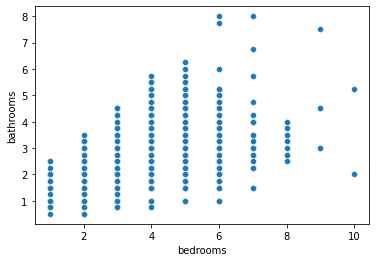

In [32]:
sns.scatterplot(x='bedrooms', y='bathrooms', data=train)

- 0.75는 또 뭐일까 싶긴하지만 일단 여기까지만 하고 넘어가주자

### 평방 피트 관련 데이터
- sqft_living : 주거 공간의 평방 피트
- sqft_lot : 부지의 평방 피트
- sqft_above : 지하실을 제외한 평방 피트
- sqft_basement : 지하실의 평방 피트
- sqft_living15 : 2015년 기준 주거 공간의 평방 피트(집을 재건축했다면, 변화가 있을 수 있음)
- sqft_lot15 : 2015년 기준 부지의 평방 피트(집을 재건축했다면, 변화가 있을 수 있음)

In [33]:
sqft_df = train.loc[:,train.columns.str.contains('sqft')]

In [34]:
sqft_df.describe()

,sqft_living,sqft_lot,sqft_above,sqft_basement,sqft_living15,sqft_lot15
count,15029.000000,1.502900e+04,15029.000000,15029.000000,15029.000000,15029.000000
mean,2084.294497,1.528351e+04,1794.546810,289.747688,1992.966132,12808.982966
std,921.921821,4.259039e+04,831.620781,440.713233,691.481161,27687.680801
min,380.000000,5.200000e+02,380.000000,0.000000,399.000000,651.000000
25%,1430.000000,5.027000e+03,1190.000000,0.000000,1490.000000,5100.000000
50%,1920.000000,7.620000e+03,1570.000000,0.000000,1850.000000,7609.000000
75%,2560.000000,1.068800e+04,2230.000000,550.000000,2360.000000,10075.000000
max,13540.000000,1.651359e+06,9410.000000,4130.000000,6210.000000,871200.000000


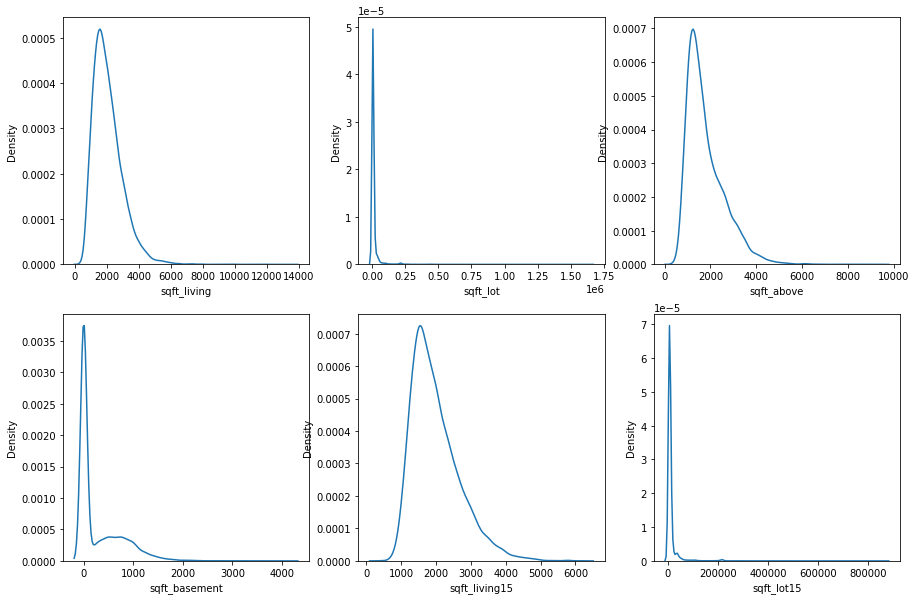

In [35]:
plt.figure(figsize = (15,10))

for i, col in enumerate(sqft_df.columns):
    plt.subplot(2,3,i+1)
    sns.kdeplot(train[col])

- 15년 데이터는 sqft_living15, sqft_lot15, 14년 데이터는 sqft_living, sqft_lot을 써야하지 않을까?
- 지하실은 0인 데이터가 상당히 많아 보인다. 지하실이 있고 없고를 기준으로 파생변수를 만들어도 되지 않을까?

### 지하실이 있는집과 없는 집의 집값 차이는?

In [36]:
(train['sqft_basement'] > 0).value_counts()

False    9137
True     5892
Name: sqft_basement, dtype: int64

In [37]:
train['basement_yn'] = train['sqft_basement'] > 0

In [38]:
test['basement_yn'] = test['sqft_basement'] > 0

<AxesSubplot:xlabel='basement_yn', ylabel='price'>

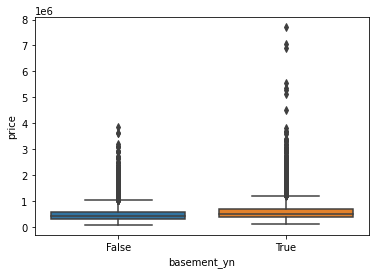

In [39]:
sns.boxplot(y='price', x='basement_yn', data=train)

- 확실히 집 값이 비싼 집은 모두 지하실이 있는 것으로 보인다

### 15년에 재개발을 한 집은?

In [40]:
sqft_df.columns

Index(['sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')

In [41]:
def calc_diff(train):
    train['sqft_living_diff'] = train['sqft_living15'] - train['sqft_living']
    train['sqft_lot_diff'] = train['sqft_lot15'] - train['sqft_lot']

In [42]:
calc_diff(train)
calc_diff(test)

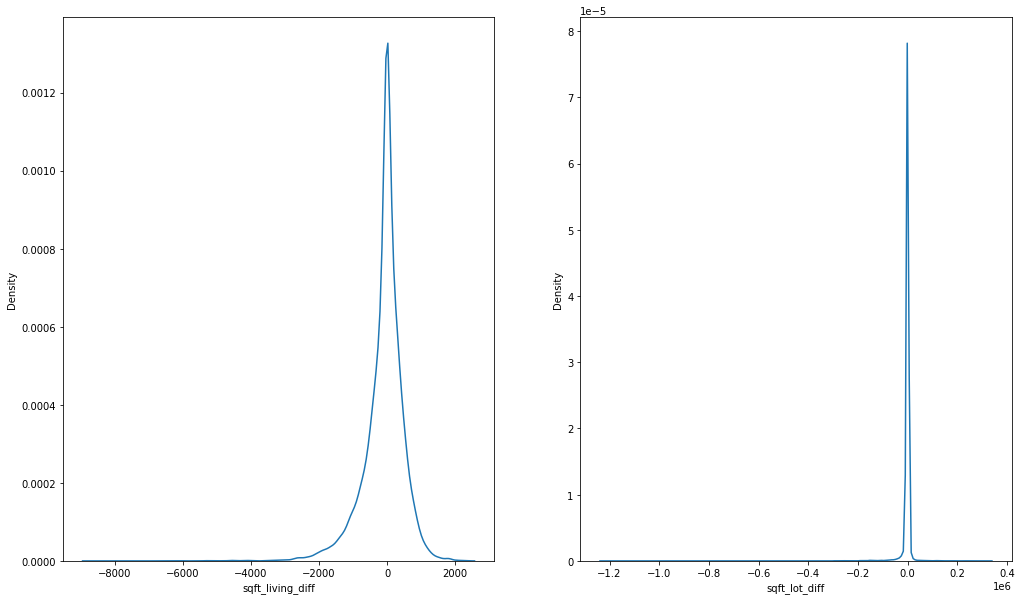

In [43]:
plt.figure(figsize = (17,10))

for i, col in enumerate(train.loc[:,train.columns.str.contains('diff')].columns):
    plt.subplot(1,2,i+1)
    sns.kdeplot(train[col])

- 너무 많이 줄어든 것들이 이상하다

In [44]:
(train.loc[:,train.columns.str.contains('diff')] != 0).value_counts()

sqft_living_diff  sqft_lot_diff
True              True             10496
                  False             2756
False             True              1418
                  False              359
dtype: int64

- 대다수의 값들이 부지크기가 변화한 것을 볼 수 있다
- 재개발을 하게 되면 집값이 상승할 수도 있지않을까? 하는 생각이 들었다.
- 이에 따라서 재개발에 대한 기대감으로 2014년에 계약했더라도 집값이 높게 측정될 수도 있다는 생각이 들어서 이 고민을 하게 되었다.
- 지금은 조금 복잡한 전처리가 될 것으로 보여지기에 추후 다시 생각해보기로 결정했다.

- 이번에는 2014년에 계약을 했다면 2014년 값을 쓰고 2015년에 계약했다면 2015년 값을 쓰는 데이터의 전처리만을 하고자한다.

### 2014년에 계약을 했다면 2014년 값을 쓰고 2015년에 계약했다면 2015년 값을 사용

In [45]:
sqft_df.columns

Index(['sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')

In [46]:
def preprocessing_sqft(df):
    df['selected_sqft_living'] = np.where(df['year'] == 2014, df['sqft_living'], df['sqft_living15'])
    df['selected_sqft_lot'] = np.where(df['year'] == 2014, df['sqft_lot'], df['sqft_lot15'])
    df.drop(['sqft_living','sqft_living15','sqft_lot','sqft_lot15'], axis=1, inplace=True)
    # 합쳐준 이름을 'sqft_living','sqft_lot'으로 바꿔준다
    df.columns = df.columns.str.replace('selected_','')

In [47]:
preprocessing_sqft(train)
preprocessing_sqft(test)

In [48]:
# train.drop(['sqft_living','sqft_living15','sqft_lot','sqft_lot15'], axis=1, inplace=True)
train.head()

,price,bedrooms,bathrooms,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,...,month,day,day_of_week,day_name,quarter,basement_yn,sqft_living_diff,sqft_lot_diff,sqft_living,sqft_lot
0,221900.0,3,1.00,1.0,0,0,3,7,1180,0,...,10,13,0,Monday,4,False,160,0,1180,5650
1,180000.0,2,1.00,1.0,0,0,3,6,770,0,...,2,25,2,Wednesday,1,False,1950,-1938,2720,8062
2,510000.0,3,2.00,1.0,0,0,3,8,1680,0,...,2,18,2,Wednesday,1,False,120,-577,1800,7503
3,257500.0,3,2.25,2.0,0,0,3,7,1715,0,...,6,27,4,Friday,2,False,523,0,1715,6819
4,291850.0,3,1.50,1.0,0,0,3,7,1060,0,...,1,15,3,Thursday,1,False,590,0,1650,9711


## 집 정보 관련 피처
- floors : 집의 층 수
- waterfront : 집의 전방에 강이 흐르는지 유무 (a.k.a. 리버뷰)

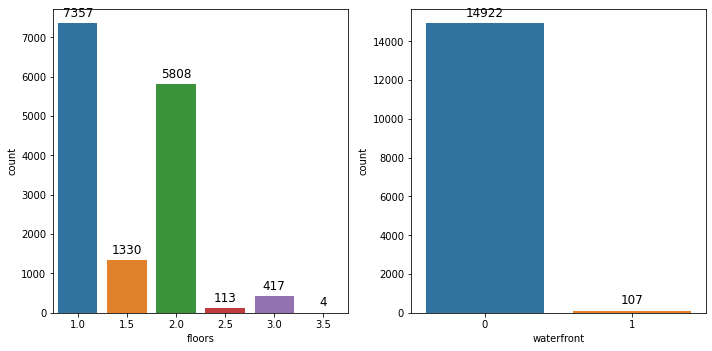

In [49]:
plt.figure(figsize=(10,5))

for i, col in enumerate(['floors', 'waterfront']):
    plt.subplot(1, 2, i+1)
    plot = sns.countplot(x=train[col])
    
    # 막대 위에 실제 수치 추가
    for p in plot.patches:
        plot.annotate(f'{p.get_height()}', 
                      (p.get_x() + p.get_width() / 2., p.get_height()), 
                      ha='center', va='center', 
                      xytext=(0, 10), 
                      textcoords='offset points',
                      fontsize=12, color='black')

plt.tight_layout()
plt.show()

## 집 위치 정보 피처
- zipcode : 우편번호
- lat : 위도
- long : 경도

### 우편번호 별 집값 분포 시각화

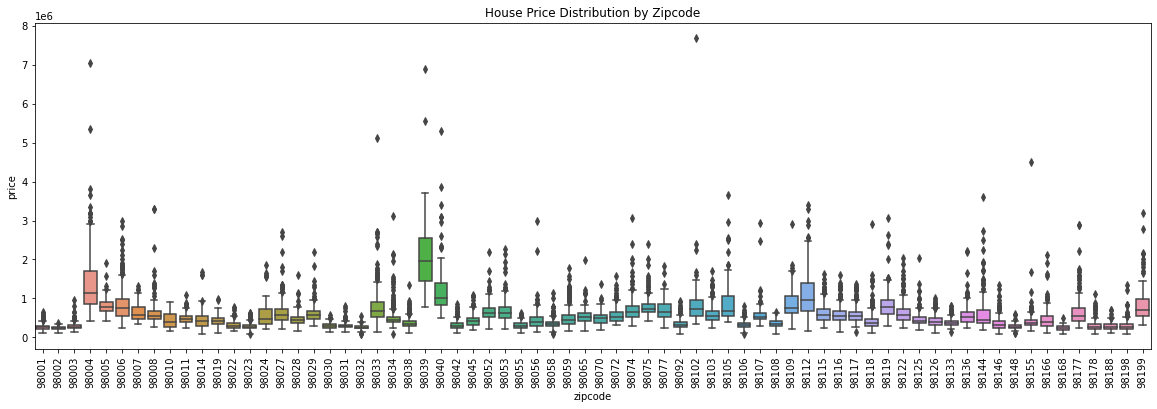

In [50]:
plt.figure(figsize=(20, 6))
sns.boxplot(x='zipcode', y='price', data=train)
plt.title('House Price Distribution by Zipcode')
plt.xticks(rotation=90)
plt.show()

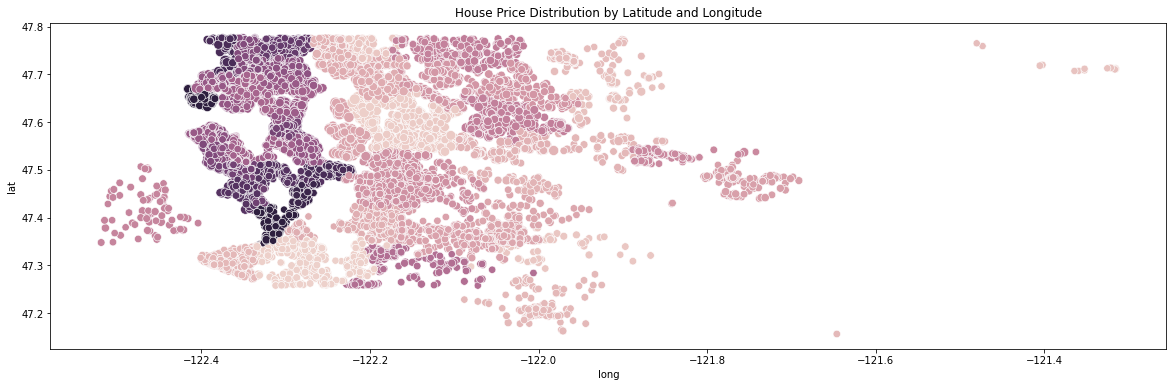

In [51]:
plt.figure(figsize=(20, 6))
sns.scatterplot(x='long', y='lat', hue='zipcode', size='price', sizes=(50, 200), data=train, legend=None)
plt.title('House Price Distribution by Latitude and Longitude')
plt.show()

- 확실히 zipcode는 위도와 경도(위치)에 따라 붙어있음을 알 수 있다

### 위도와 경도에 따른 집값 시각화

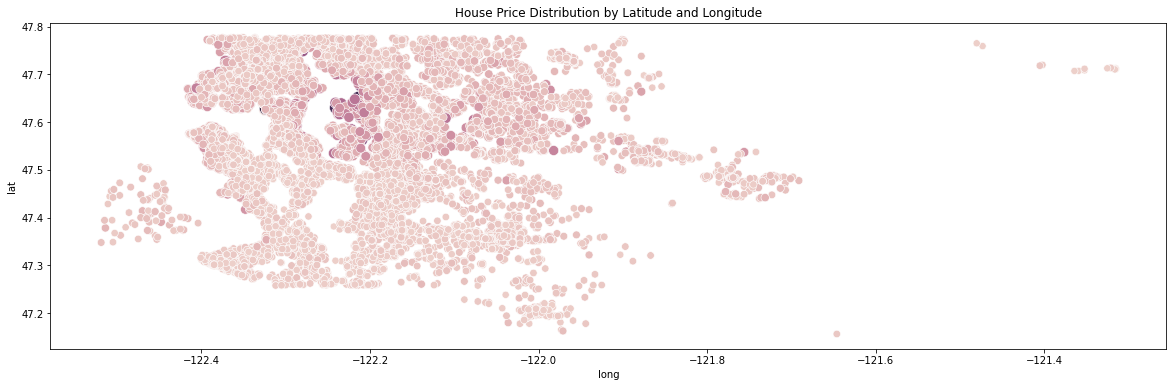

In [52]:
plt.figure(figsize=(20, 6))
sns.scatterplot(x='long', y='lat', hue='price', size='price', sizes=(50, 200), data=train, legend=None)
plt.title('House Price Distribution by Latitude and Longitude')
plt.show()

### 파생변수 생성
- zipcode별 집값의 중앙값을 파생변수로 생성한다
- 평균을 이용한다면 이상치의 영향을 받을 수도 있기에 중앙값을 이용하였다

In [53]:
median_price_by_zipcode = train.groupby('zipcode')['price'].median().reset_index()
median_price_by_zipcode.columns = ['zipcode', 'median_price']
train = train.merge(median_price_by_zipcode, on='zipcode')

In [54]:
# test data에도 같은 처리를 해준다
test = test.merge(median_price_by_zipcode, on='zipcode')

In [55]:
train.head()

,price,bedrooms,bathrooms,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,...,day,day_of_week,day_name,quarter,basement_yn,sqft_living_diff,sqft_lot_diff,sqft_living,sqft_lot,median_price
0,221900.0,3,1.00,1.0,0,0,3,7,1180,0,...,13,0,Monday,4,False,160,0,1180,5650,273500.0
1,205425.0,2,1.00,1.0,0,0,4,6,880,0,...,23,0,Monday,2,False,310,0,880,6780,273500.0
2,445000.0,3,2.25,1.0,0,2,3,8,1620,480,...,17,3,Thursday,3,True,560,511,2100,8201,273500.0
3,170000.0,2,1.00,1.0,0,0,3,6,860,0,...,27,4,Friday,1,False,790,3510,1650,8775,273500.0
4,245000.0,3,1.75,1.0,0,0,3,7,1740,0,...,1,4,Friday,2,False,-860,66861,880,78408,273500.0


### 연도 관련 피처
- yr_built : 집을 지은 년도
- yr_renovated : 집을 재건축한 년도

In [56]:
train[['yr_built', 'yr_renovated']].describe()

,yr_built,yr_renovated
count,15029.000000,15029.000000
mean,1971.098277,83.832391
std,29.409568,400.474919
min,1900.000000,0.000000
25%,1951.000000,0.000000
50%,1975.000000,0.000000
75%,1997.000000,0.000000
max,2015.000000,2015.000000


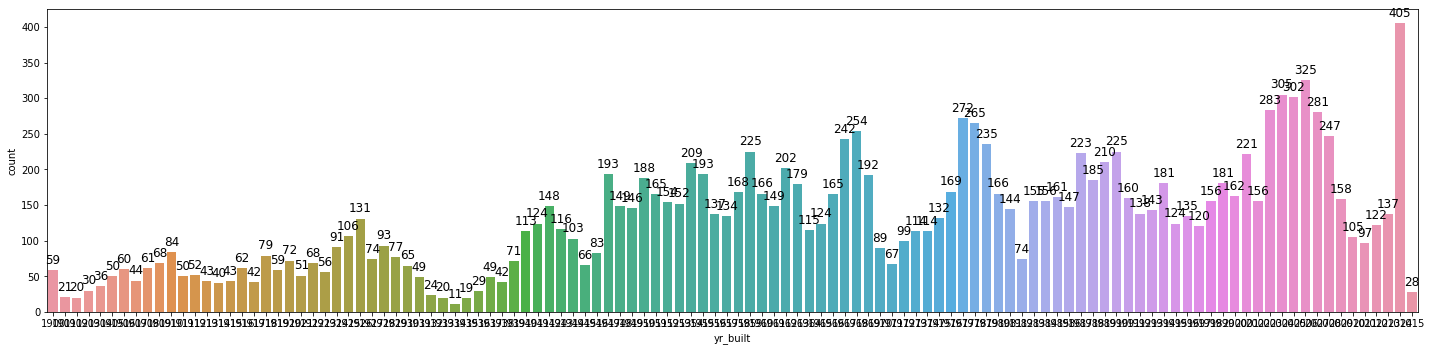

In [57]:
plt.figure(figsize=(20,5))
plot = sns.countplot(x=train['yr_built'])

# 막대 위에 실제 수치 추가
for p in plot.patches:
    plot.annotate(f'{p.get_height()}', 
                  (p.get_x() + p.get_width() / 2., p.get_height()), 
                  ha='center', va='center', 
                  xytext=(0, 10), 
                  textcoords='offset points',
                  fontsize=12, color='black')

plt.tight_layout()
plt.show()

- 생각보다 오래된 건물들이 많이 있었다

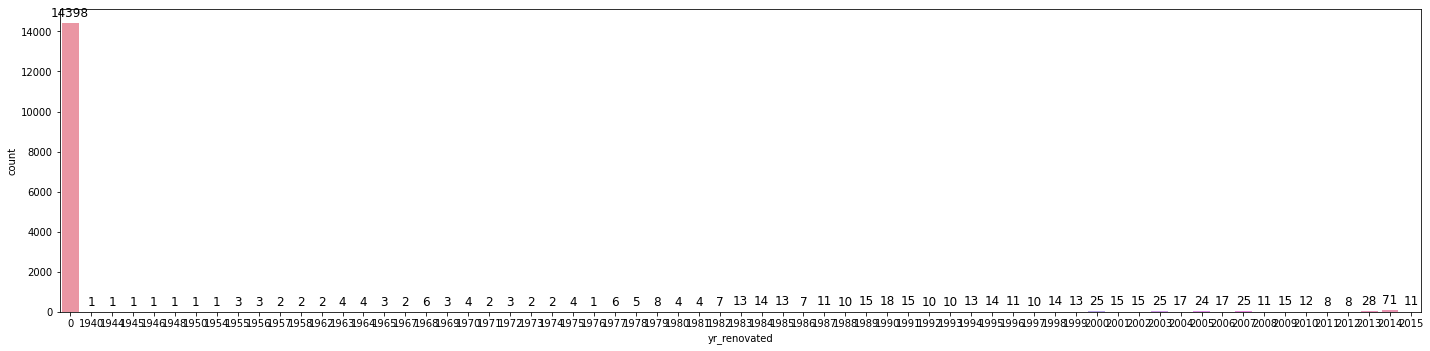

In [58]:
plt.figure(figsize=(20,5))
plot = sns.countplot(x=train['yr_renovated'])

# 막대 위에 실제 수치 추가
for p in plot.patches:
    plot.annotate(f'{p.get_height()}', 
                  (p.get_x() + p.get_width() / 2., p.get_height()), 
                  ha='center', va='center', 
                  xytext=(0, 10), 
                  textcoords='offset points',
                  fontsize=12, color='black')

plt.tight_layout()
plt.show()

- 재건축을 안한 집이 많아서 잘 보이지 않는다

0을 빼고 다시 시각화를 진행하였다

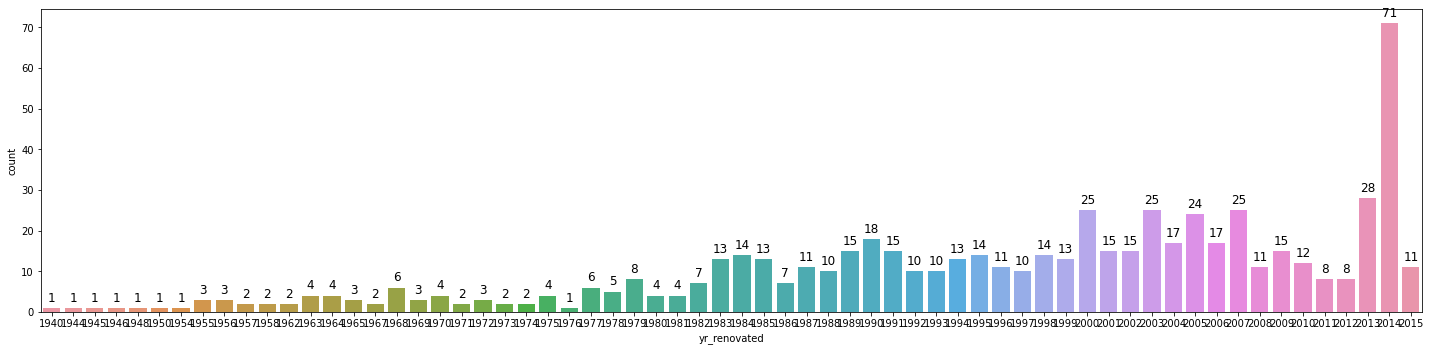

In [59]:
plt.figure(figsize=(20,5))
plot = sns.countplot(x=train.loc[train['yr_renovated']>0,'yr_renovated'])

# 막대 위에 실제 수치 추가
for p in plot.patches:
    plot.annotate(f'{p.get_height()}', 
                  (p.get_x() + p.get_width() / 2., p.get_height()), 
                  ha='center', va='center', 
                  xytext=(0, 10), 
                  textcoords='offset points',
                  fontsize=12, color='black')

plt.tight_layout()
plt.show()

- 2014년에 재건축이 많았다

### 재건축 여부도 파생변수로 추가

In [60]:
train['renovated_yn'] = train['yr_renovated'] > 0
test['renovated_yn'] = test['yr_renovated'] > 0

### 파생변수 생성
**집 나이 계산**:
   - `np.where` 함수를 사용하여 조건을 설정하여 집 나이를 계산한다.
     - 만약 `yr_renovated` 값이 `0`이 아니면, 즉 재건축이 되었으면 `year - yr_renovated`를 계산한다.
     - 그렇지 않으면 `year - yr_built`를 계산한다.
   - 이를 통해 `house_age`라는 새로운 컬럼을 생성

In [61]:
def calc_age(df):
    df['house_age'] = np.where(df['yr_renovated'] != 0, df['year'] - df['yr_renovated'], df['year'] - df['yr_built'])

In [62]:
calc_age(train)

In [63]:
calc_age(test)

### 집에 대한 평가 피처
- view : 집이 얼마나 좋아 보이는지의 정도
- condition : 집의 전반적인 상태
- grade : King County grading 시스템 기준으로 매긴 집의 등급

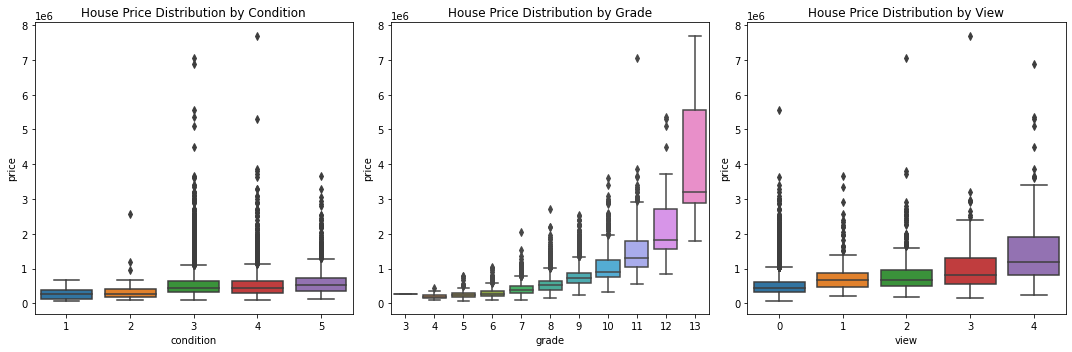

In [64]:
# 1. Condition별 집값 분포 시각화
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
sns.boxplot(x='condition', y='price', data=train)
plt.title('House Price Distribution by Condition')

# 2. Grade별 집값 분포 시각화
plt.subplot(1, 3, 2)
sns.boxplot(x='grade', y='price', data=train)
plt.title('House Price Distribution by Grade')

# 3. View 등급별 집값 분포 시각화
plt.subplot(1, 3, 3)
sns.boxplot(x='view', y='price', data=train)
plt.title('House Price Distribution by View')

plt.tight_layout()
plt.show()

- 확실히 집 상태의 평가가 높아지면 더 값이 비싸지는 경향을 볼 수 있다

### 파생변수 생성
- view, condition, grade의 평균을 파생변수로 생성하고자 한다

In [65]:
def get_score(df):
    df['score'] = df[['view', 'condition', 'grade']].mean(axis=1)

In [66]:
get_score(train)

In [67]:
get_score(test)

## 피처 선정

In [68]:
train

,price,bedrooms,bathrooms,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,...,quarter,basement_yn,sqft_living_diff,sqft_lot_diff,sqft_living,sqft_lot,median_price,renovated_yn,house_age,score
0,221900.0,3,1.00,1.0,0,0,3,7,1180,0,...,4,False,160,0,1180,5650,273500.0,False,59,3.333333
1,205425.0,2,1.00,1.0,0,0,4,6,880,0,...,2,False,310,0,880,6780,273500.0,False,69,3.333333
2,445000.0,3,2.25,1.0,0,2,3,8,1620,480,...,3,True,560,511,2100,8201,273500.0,False,47,4.333333
3,170000.0,2,1.00,1.0,0,0,3,6,860,0,...,1,False,790,3510,1650,8775,273500.0,False,84,3.000000
4,245000.0,3,1.75,1.0,0,0,3,7,1740,0,...,2,False,-860,66861,880,78408,273500.0,False,61,3.333333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15024,3635000.0,5,6.00,2.0,0,0,3,12,5490,0,...,4,False,-2580,-2297,5490,19897,1950000.0,False,9,5.000000
15025,2720000.0,4,3.25,2.0,0,0,4,11,3990,0,...,4,False,-540,-2028,3990,18115,1950000.0,False,25,5.000000
15026,1950000.0,4,3.50,2.0,0,0,4,10,4065,0,...,3,False,-995,0,4065,18713,1950000.0,False,27,4.666667
15027,2250000.0,5,5.25,2.0,0,0,3,11,3410,0,...,2,False,0,8118,3410,16236,1950000.0,False,9,4.666667


In [69]:
train.columns

Index(['price', 'bedrooms', 'bathrooms', 'floors', 'waterfront', 'view',
       'condition', 'grade', 'sqft_above', 'sqft_basement', 'yr_built',
       'yr_renovated', 'zipcode', 'lat', 'long', 'year', 'month', 'day',
       'day_of_week', 'day_name', 'quarter', 'basement_yn', 'sqft_living_diff',
       'sqft_lot_diff', 'sqft_living', 'sqft_lot', 'median_price',
       'renovated_yn', 'house_age', 'score'],
      dtype='object')

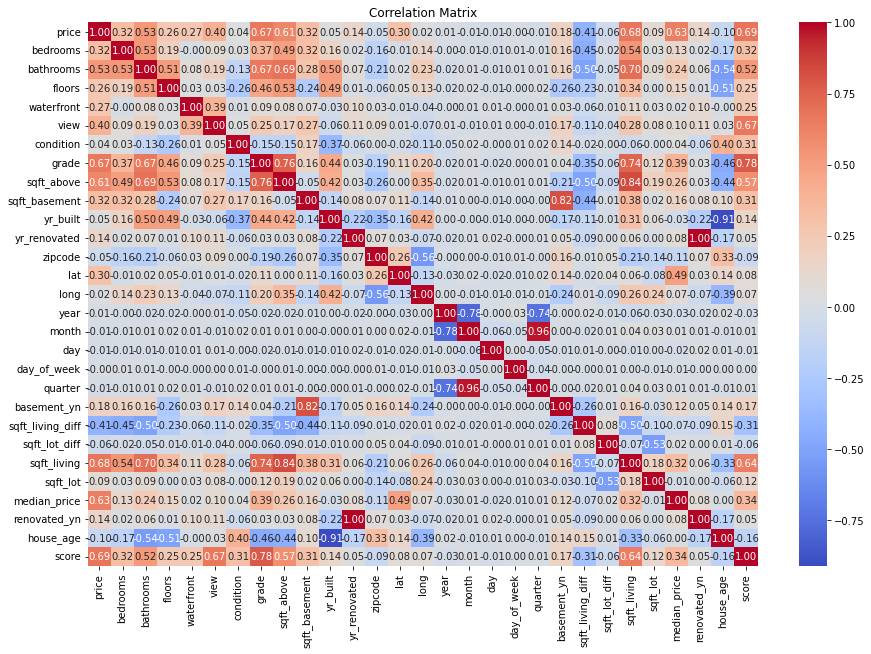

In [70]:
df = train.copy()

## 상관관계 분석
plt.figure(figsize=(15, 10))
correlation_matrix = df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

### 상관관계 분석 결과에 따라 필요 없는 컬럼 제거
- 0.1 이하 상관관계의 컬럼 삭제

In [71]:
drop_cols = correlation_matrix.columns[np.abs(correlation_matrix.price) < 0.1]

In [72]:
train.drop(drop_cols, axis=1, inplace=True)

In [73]:
train.columns

Index(['price', 'bedrooms', 'bathrooms', 'floors', 'waterfront', 'view',
       'grade', 'sqft_above', 'sqft_basement', 'yr_renovated', 'lat',
       'day_name', 'basement_yn', 'sqft_living_diff', 'sqft_living',
       'median_price', 'renovated_yn', 'house_age', 'score'],
      dtype='object')

In [74]:
test.drop(drop_cols, axis=1, inplace=True)

In [75]:
train.shape

(15029, 19)

In [76]:
train.head()

,price,bedrooms,bathrooms,floors,waterfront,view,grade,sqft_above,sqft_basement,yr_renovated,lat,day_name,basement_yn,sqft_living_diff,sqft_living,median_price,renovated_yn,house_age,score
0,221900.0,3,1.00,1.0,0,0,7,1180,0,0,47.5112,Monday,False,160,1180,273500.0,False,59,3.333333
1,205425.0,2,1.00,1.0,0,0,6,880,0,0,47.5009,Monday,False,310,880,273500.0,False,69,3.333333
2,445000.0,3,2.25,1.0,0,2,8,1620,480,0,47.5091,Thursday,True,560,2100,273500.0,False,47,4.333333
3,170000.0,2,1.00,1.0,0,0,6,860,0,0,47.5048,Friday,False,790,1650,273500.0,False,84,3.000000
4,245000.0,3,1.75,1.0,0,0,7,1740,0,0,47.4945,Friday,False,-860,880,273500.0,False,61,3.333333


In [77]:
train.shape

(15029, 19)

In [78]:
test.shape

(6468, 18)

In [79]:
train.columns

Index(['price', 'bedrooms', 'bathrooms', 'floors', 'waterfront', 'view',
       'grade', 'sqft_above', 'sqft_basement', 'yr_renovated', 'lat',
       'day_name', 'basement_yn', 'sqft_living_diff', 'sqft_living',
       'median_price', 'renovated_yn', 'house_age', 'score'],
      dtype='object')

In [80]:
test.columns

Index(['bedrooms', 'bathrooms', 'floors', 'waterfront', 'view', 'grade',
       'sqft_above', 'sqft_basement', 'yr_renovated', 'lat', 'day_name',
       'basement_yn', 'sqft_living_diff', 'sqft_living', 'median_price',
       'renovated_yn', 'house_age', 'score'],
      dtype='object')

In [86]:
train.drop('day_name', axis=1, inplace=True)
test.drop('day_name', axis=1, inplace=True)

## 모델링

In [87]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, VotingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [114]:
# 데이터 분할 (Train, Validation, Test)
y = train['price']
y = np.log1p(y)

X = train.drop('price', axis=1)

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42)
# 테스트 데이터
X_test = test

# 표준화
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

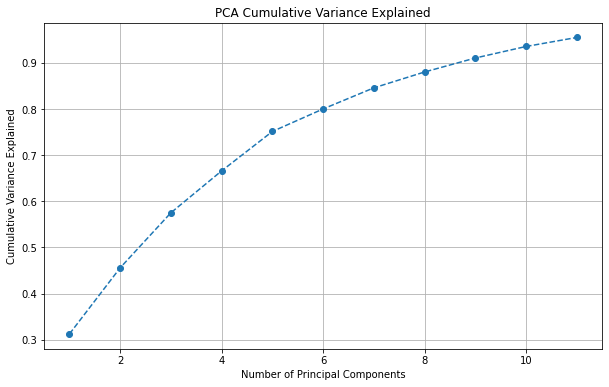

In [115]:
# PCA 적용
pca = PCA(n_components=0.95)  # 분산의 95%를 유지하는 주성분 개수를 선택
X_train_pca = pca.fit_transform(X_train)
X_val_pca = pca.transform(X_val)
X_test_pca = pca.transform(X_test)

# PCA 결과 시각화
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance_ratio = np.cumsum(explained_variance_ratio)

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cumulative_variance_ratio) + 1), cumulative_variance_ratio, marker='o', linestyle='--')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Variance Explained')
plt.title('PCA Cumulative Variance Explained')
plt.grid(True)
plt.show()

## 모델 도입 및 평가

### 모델 및 평가 지표 선정 이유
- 선택한 모델: 앙상블 모델 (랜덤 포레스트, 그래디언트 부스팅, 배깅)
    - 선정 이유: 앙상블 모델은 여러 모델의 예측을 결합하여 예측 성능을 향상시키며, 단일 모델보다 일반화 성능이 뛰어나다.

- 평가 지표: RMSE(Root Mean Squared Error)
    - 선정 이유: RMSE는 예측 값과 실제 값 간의 차이를 제곱한 후 평균을 구해 루트를 취한다. 단위가 타깃 변수의 단위와 같아 해석이 용이하고, 큰 오차에 더 큰 패널티를 부여한다.

########################################
Ensemble Models
########################################
Train RMSE: 0.12792045963449564
Validation RMSE: 0.19820819171989748
Best Train RMSE: 0.12265233556056052
Best Validation RMSE: 0.196135476122779


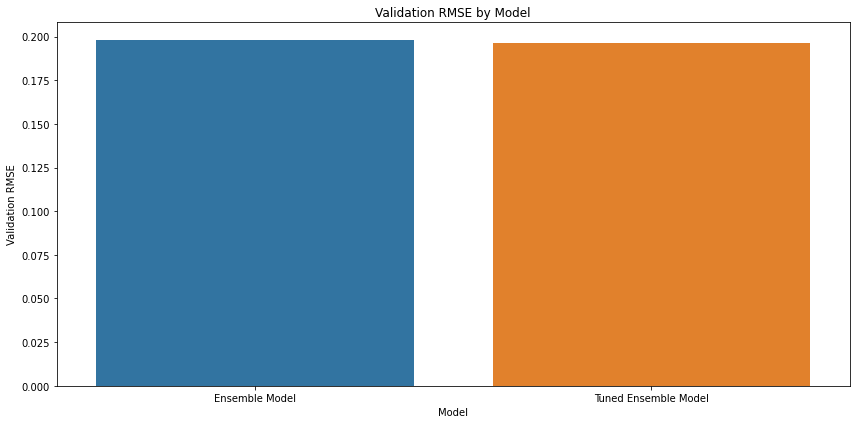

                  Model  Train RMSE  Validation RMSE
0        Ensemble Model    0.127920         0.198208
1  Tuned Ensemble Model    0.122652         0.196135


In [116]:
"""
선택한 모델: 앙상블 모델 (랜덤 포레스트, 그래디언트 부스팅, 배깅)
선정 이유: 앙상블 모델은 여러 모델의 예측을 결합하여 예측 성능을 향상시키며, 단일 모델보다 일반화 성능이 뛰어나다.

평가 지표: RMSE(Root Mean Squared Error)
선정 이유: RMSE는 예측 값과 실제 값 간의 차이를 제곱한 후 평균을 구해 루트를 취합니다. 단위가 타깃 변수의 단위와 같아 해석이 용이하고,
큰 오차에 더 큰 패널티를 부여합니다.
"""

## 앙상블 모델 학습 및 평가
print("#" * 40)
print("Ensemble Models")
print("#" * 40)

# 랜덤 포레스트 모델 설정 및 학습
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train_pca, y_train)

# 그래디언트 부스팅 모델 설정 및 학습
gbr_model = GradientBoostingRegressor(n_estimators=100, random_state=42)
gbr_model.fit(X_train_pca, y_train)

# 앙상블 모델 (Voting Regressor)
ensemble_model = VotingRegressor([('rf', rf_model), ('gbr', gbr_model)])
ensemble_model.fit(X_train_pca, y_train)

y_train_pred = ensemble_model.predict(X_train_pca)
y_val_pred = ensemble_model.predict(X_val_pca)

train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
val_rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))

print("Train RMSE:", train_rmse)
print("Validation RMSE:", val_rmse)

# 하이퍼파라미터 튜닝을 위한 GridSearchCV 사용
param_grid = {
    'rf__n_estimators': [50, 100, 200],
    'gbr__n_estimators': [50, 100, 200],
}

grid_search = GridSearchCV(estimator=ensemble_model, param_grid=param_grid, cv=3, scoring='neg_mean_squared_error')
grid_search.fit(X_train_pca, y_train)

best_model = grid_search.best_estimator_

y_train_pred_best = best_model.predict(X_train_pca)
y_val_pred_best = best_model.predict(X_val_pca)

train_rmse_best = np.sqrt(mean_squared_error(y_train, y_train_pred_best))
val_rmse_best = np.sqrt(mean_squared_error(y_val, y_val_pred_best))

print("Best Train RMSE:", train_rmse_best)
print("Best Validation RMSE:", val_rmse_best)

# 실험 결과 시각화
results = pd.DataFrame({
    "Model": ["Ensemble Model", "Tuned Ensemble Model"],
    "Train RMSE": [train_rmse, train_rmse_best],
    "Validation RMSE": [val_rmse, val_rmse_best]
})

plt.figure(figsize=(12, 6))
ax1 = plt.subplot(1, 1, 1)
sns.barplot(x="Model", y="Validation RMSE", data=results, ax=ax1)
plt.title('Validation RMSE by Model')
plt.tight_layout()
plt.show()

print(results)

In [159]:
best_model = grid_search.best_estimator_

In [160]:
y_train_pred_best = best_model.predict(X_train_pca)
y_val_pred_best = best_model.predict(X_val_pca)

In [161]:
y_train_pred_best = np.expm1(y_train_pred_best)
y_val_pred_best = np.expm1(y_val_pred_best)

In [162]:
train_rmse_best = np.sqrt(mean_squared_error(y_train, y_train_pred_best))
val_rmse_best = np.sqrt(mean_squared_error(y_val, y_val_pred_best))

In [163]:
print("Best Train RMSE:", train_rmse_best)
print("Best Validation RMSE:", val_rmse_best)

Best Train RMSE: 632866.4579560078
Best Validation RMSE: 599410.4583906267


In [ ]:
# 실험 결과 시각화
results = pd.DataFrame({
    "Model": ["Ensemble Model", "Tuned Ensemble Model"],
    "Train RMSE": [train_rmse, train_rmse_best],
    "Validation RMSE": [val_rmse, val_rmse_best]
})

plt.figure(figsize=(12, 6))
ax1 = plt.subplot(1, 1, 1)
sns.barplot(x="Model", y="Validation RMSE", data=results, ax=ax1)
plt.title('Validation RMSE by Model')
plt.tight_layout()
plt.show()

print(results)

In [136]:
prediction = best_model.predict(X_test_pca)
prediction = np.expm1(prediction)

In [137]:
data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'

submission_path = join(data_dir, 'sample_submission.csv')
submission = pd.read_csv(submission_path)
submission.head()

submission['price'] = prediction
submission.head()

,id,price
0,15035,623849.808351
1,15036,411783.025463
2,15037,334208.228007
3,15038,572569.450026
4,15039,480241.508000


In [138]:
submission.to_csv('submission_pca.csv', index=False)

In [139]:
from sklearn.model_selection import KFold, cross_val_score, train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
import xgboost as xgb
import lightgbm as lgb

In [140]:
# random_state는 모델초기화나 데이터셋 구성에 사용되는 랜덤 시드값입니다. 
#random_state=None    # 이게 초기값입니다. 아무것도 지정하지 않고 None을 넘겨주면 모델 내부에서 임의로 선택합니다.  
random_state=2020        # 하지만 우리는 이렇게 고정값을 세팅해 두겠습니다. 

gboost = GradientBoostingRegressor(random_state=random_state)
xgboost = XGBRegressor(random_state=random_state)
lightgbm = LGBMRegressor(random_state=random_state)
rdforest = RandomForestRegressor(random_state=random_state)

models = [gboost, xgboost, lightgbm, rdforest]

In [141]:
def rmse(y_test, y_pred):
    return np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred)))

In [142]:
def get_scores(models, X, y):
    df = {}

    for model in models:
    # 모델 이름 획득
        model_name = model.__class__.__name__

        # train, test 데이터셋 분리
        # random_state를 사용하여 고정하고 train과 test 셋의 비율은 8:2로 합니다.
        X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=random_state, test_size=0.2)

        # 모델 학습
        model.fit(X_train, y_train)
        
        # 예측
        y_pred = model.predict(X_test)

        # 예측 결과의 rmse값 저장
        df[model_name] = rmse(y_test, y_pred)
        
        # data frame에 저장
        score_df = pd.DataFrame(df, index=['RMSE']).T.sort_values('RMSE', ascending=False)

    return score_df

get_scores(models, X, y)

,RMSE
RandomForestRegressor,131566.810248
GradientBoostingRegressor,122362.481274
XGBRegressor,117746.529696
LGBMRegressor,115936.557715


## XGB

In [156]:
xgb_params = {
    'eta': 0.01,
    'max_depth': 6,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'objective': 'reg:linear',
    'eval_metric': 'rmse',
    'silent': 1
}

In [157]:
dtrain = xgb.DMatrix(X_train, y_train)
dtest = xgb.DMatrix(X_test)

cv_output = xgb.cv(xgb_params, dtrain, num_boost_round=5000, early_stopping_rounds=50, verbose_eval=500, show_stdv=False)

rounds=len(cv_output)

xgb1 = xgb.train(xgb_params, dtrain, num_boost_round=rounds)
preds = xgb1.predict(dtest)

[07:39:25] WARNING: ../src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[07:39:25] WARNING: ../src/learner.cc:573: 
Parameters: { "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[07:39:25] WARNING: ../src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[07:39:25] WARNING: ../src/learner.cc:573: 
Parameters: { "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[07:39:25] WARNING: ../src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:s

In [165]:
preds = np.expm1(preds)

In [166]:
submission['price'] = preds
submission.head()

,id,price
0,15035,535909.18750
1,15036,446663.68750
2,15037,311858.96875
3,15038,442433.50000
4,15039,513744.21875


In [168]:
submission.to_csv('submission_xgb.csv', index=False)

## 하이퍼 파라미터 튜닝의 최강자, 그리드 탐색

In [143]:
from sklearn.model_selection import GridSearchCV

In [ ]:
"""
다음과 같은 과정을 진행할 수 있는 `my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5)` 함수를 구현해 보세요.

1. GridSearchCV 모델로 `model`을 초기화합니다.
2. 모델을 fitting 합니다.
3. params, score에 각 조합에 대한 결과를 저장합니다. 
4. 데이터 프레임을 생성하고, RMSLE 값을 추가한 후 점수가 높은 순서로 정렬한 `results`를 반환합니다.
"""

In [153]:
def my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5):
    # GridSearchCV 모델로 초기화
    grid_model = GridSearchCV(model, param_grid=param_grid, scoring='neg_mean_squared_error', \
                              cv=5, verbose=verbose, n_jobs=n_jobs)
    
    # 모델 fitting
    grid_model.fit(train, y)

    # 결과값 저장
    params = grid_model.cv_results_['params']
    score = grid_model.cv_results_['mean_test_score']
    
    # 데이터 프레임 생성
    results = pd.DataFrame(params)
    results['score'] = score
    
    # RMSLE 값 계산 후 정렬
    results['RMSLE'] = np.sqrt(-1 * results['score'])
    results = results.sort_values('RMSLE')

    return results

param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [1, 10],
}

model = LGBMRegressor(random_state=random_state)
my_GridSearch(model, X, y, param_grid, verbose=2, n_jobs=5)

model = LGBMRegressor(max_depth=10, n_estimators=100, random_state=random_state)
model.fit(X, y)
prediction = model.predict(X_test)
prediction = np.expm1(prediction)
prediction

data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'

submission_path = join(data_dir, 'sample_submission.csv')
submission = pd.read_csv(submission_path)
submission.head()

submission['price'] = prediction
submission.head()

submission_csv_path = '{}/submission_{}_RMSLE_{}.csv'.format(data_dir, 'lgbm', '0.164399')
submission.to_csv(submission_csv_path, index=False)
print(submission_csv_path)

"""
아래의 과정을 수행하는 `save_submission(model, train, y, test, model_name, rmsle)` 함수를 구현해 주세요.
1. 모델을 `train`, `y`로 학습시킵니다.
2. `test`에 대해 예측합니다.
3. 예측값을 `np.expm1`으로 변환하고, `submission_model_name_RMSLE_100000.csv` 형태의 `csv` 파일을 저장합니다.
"""

def save_submission(model, train, y, test, model_name, rmsle=None):
    model.fit(train, y)
    prediction = model.predict(test)
    prediction = np.expm1(prediction)
    data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'
    submission_path = join(data_dir, 'sample_submission.csv')
    submission = pd.read_csv(submission_path)
    submission['price'] = prediction
    submission_csv_path = '{}/submission_{}_RMSLE_{}.csv'.format(data_dir, model_name, rmsle)
    submission.to_csv(submission_csv_path, index=False)
    print('{} saved!'.format(submission_csv_path))


Fitting 5 folds for each of 4 candidates, totalling 20 fits
/aiffel/aiffel/kaggle_kakr_housing/data/submission_lgbm_RMSLE_0.164399.csv
[CV] END .......................max_depth=1, n_estimators=50; total time=   0.4s
[CV] END ......................max_depth=1, n_estimators=100; total time=   0.7s
[CV] END ......................max_depth=10, n_estimators=50; total time=   1.1s
[CV] END .....................max_depth=10, n_estimators=100; total time=   1.5s
[CV] END .......................max_depth=1, n_estimators=50; total time=   0.4s
[CV] END ......................max_depth=1, n_estimators=100; total time=   0.6s
[CV] END ......................max_depth=10, n_estimators=50; total time=   1.0s
[CV] END .....................max_depth=10, n_estimators=100; total time=   1.4s
[CV] END .......................max_depth=1, n_estimators=50; total time=   0.6s
[CV] END ......................max_depth=1, n_estimators=100; total time=   0.5s
[CV] END ......................max_depth=10, n_estimato

In [154]:
models

[GradientBoostingRegressor(random_state=2020),
 XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=2, num_parallel_tree=1, random_state=2020,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None),
 LGBMRegressor(random_state=2020),
 RandomForestRegressor(random_state=2020)]

### 최종 결과

- 데이터 분석을 하다가 시간을 많이 써서 좋은 결과를 내는데 생각보다 시간을 많이 못써서 아쉽다.
- 다음에는 시간분배를 좀 더 잘 해봐야겠다